In [27]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import re
from rdkit.Chem import Draw
from rdkit.Chem import MACCSkeys
import numpy as np
import torch
import torch.nn as nn
import torch.utils
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from tqdm import tqdm
import os
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from SoftNet import SoftNet, train_SoftNet, GetLoader
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
#import dgl




## data pre-process

In [2]:
from torch_geometric.data import Data

def convert(z):
    re = []
    for i in z:
        if i == 'H' or i == 'R':
            re.append(1)
        elif i == 'C':
            re.append(4)
        elif i == 'O':
            re.append(6)
        elif i == 'F':
            re.append(9)
        elif i == 'Cl':
            re.append(17)
        elif i == 'N':
            re.append(7)
        elif i == 'Br':
            re.append(35)
        elif i == 'I':
            re.append(53)
        elif i == 'S':
            re.append(16)
        elif i == 'P':
            re.append(15)
    assert len(re) == len(z)
    return re

def smiles_to_Data(statis):
    pos = []
    z = []
    for i in statis:
        pos.append(list([float(i[0]), float(i[1]),float(i[2])]))
        z.append((i[3]))
        data_tmp = Data(
            pos=torch.as_tensor(pos, dtype=torch.float32),
            z = torch.as_tensor(convert(z), dtype=torch.int64),
            natoms = torch.as_tensor(len(z), dtype=torch.int64)
        )
    return data_tmp

In [3]:
from tqdm import tqdm

data = pd.read_csv('/mnt/workspace/xuhan/github-repo/chemprop-master/radonpy/soft-schnet/PI1070.csv')
data = data.fillna(0)
data = data.drop(data.index[[13, 14, 506, 507, 508, 535, 569, 609, 621, 622, 623, 625, 626, 627, 628, 804, 806, 807, 1068]])

In [ ]:
graph_smiles = []

for i in tqdm(data['smiles']):
    print(i)
    mol= Chem.MolFromSmiles(i)
    mol3d = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol3d, randomSeed=1)
    statis = Chem.MolToMolBlock(mol3d)
    statis = re.findall(r'(-?\d.\d+)\s+(-?\d.\d+)\s+(-?\d.\d+)\s(\w)\s+', statis)
    data_tmp = smiles_to_Data(statis)
    graph_smiles.append(data_tmp)

In [61]:
y0 = np.array(data['thermal_conductivity']).reshape(-1,1)
y1 = np.array(data['thermal_diffusivity']).reshape(-1,1) #(1077, 1)
y2 = np.array(data['dielectric_const_dc']).reshape(-1,1) #(1077, 1)
y3 = np.array(data['volume_expansion']).reshape(-1,1) #(1077, 1)
y = np.concatenate((y0, y1, y2, y3), axis=1)

X1 = np.array(data['mol_weight_monomer']).reshape(-1,1) #(1077, 1)
X2 = np.array(data['vdw_volume_monomer']).reshape(-1,1) #(1077, 1)
X3 = np.array(data['qm_total_energy_monomer']).reshape(-1,1) #(1077, 1)
X4 = np.array(data['qm_homo_monomer']).reshape(-1,1) #(1077, 1)
X5 = np.array(data['qm_lumo_monomer']).reshape(-1,1) #(1077, 1)
X6 = np.array(data['qm_dipole_monomer']).reshape(-1,1) #(1077, 1)
X7 = np.array(data['qm_polarizability_monomer']).reshape(-1,1) #(1077, 1)
X8 = np.array(data['DP']).reshape(-1,1) #(1077, 1)  
X9 = np.array(data['Mn']).reshape(-1,1) #(1077, 1)
X10 = np.array(data['density']).reshape(-1,1) #(1077, 1)
X11 = np.array(data['compressibility']).reshape(-1,1) #(1077, 1)
X12 = np.array(data['static_dielectric_const']).reshape(-1,1) #(1077, 1)
X13 = np.array(data['nematic_order_parameter']).reshape(-1,1) #(1077, 1)

X = np.concatenate((X1, X2, X3, X4, X5, X6, X7, X8,X9,X10,X11,X12,X13), axis=1)
scalar = StandardScaler()

X = scalar.fit_transform(X)
y = scalar.fit_transform(y)

In [66]:
y = torch.tensor(y)
y.shape
radondata = []
for i in tqdm(range(y.shape[0])):
    
    data_tmp = Data(
            pos=torch.as_tensor(graph_smiles[i].pos, dtype=torch.float32),
            z = torch.as_tensor(graph_smiles[i].z, dtype=torch.int64),
            natoms = torch.as_tensor(graph_smiles[i].natoms, dtype=torch.int64),
            monmer_y = torch.as_tensor(X[i, :7], dtype=torch.float32),
            chain = torch.as_tensor(X[i, 7:12], dtype=torch.float32),
            order = torch.as_tensor(X[i, 12], dtype=torch.float32),
            y = torch.as_tensor(y[i, :], dtype=torch.float32)
        )
    radondata.append(data_tmp)
    
torch.save( radondata, 'data_polymer_scaled.pt')

/tmp/ipykernel_7731/1065594577.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y)
100%|██████████| 1058/1058 [00:00<00:00, 18307.50it/s]


In [10]:
y = torch.tensor(y)
y.shape
radondata = []
for i in tqdm(range(y.shape[0])):
    
    data_tmp = Data(
            pos=torch.as_tensor(graph_smiles[i].pos, dtype=torch.float32),
            z = torch.as_tensor(graph_smiles[i].z, dtype=torch.int64),
            natoms = torch.as_tensor(graph_smiles[i].natoms, dtype=torch.int64),
            y = torch.as_tensor(y[i, :], dtype=torch.float32)
        )
    radondata.append(data_tmp)
    
torch.save( radondata, 'data_monomer.pt')

100%|██████████| 1058/1058 [00:00<00:00, 32911.63it/s]


In [2]:
# data = torch.load('/mnt/workspace/xuhan/github-repo/chemprop-master/radonpy/data_polymer_scaled.pt')
# data = torch.load('/mnt/workspace/xuhan/github-repo/chemprop-master/radonpy/soft-schnet/data_polymer.pt')
data = torch.load('data_polymer_scaled.pt')
data[0]

Data(y=[4], pos=[8, 3], z=[8], natoms=8, monmer_y=[7], chain=[5], order=-1.0069321393966675)

## model evaluation

In [131]:
import torch
from schnet_concat import SchNet # if schnet
from schnet import SchNet # if softschnet
from evaluation import ThreeDEvaluator
from run import run
from torch.utils.data import Subset
import numpy as np


# Load the dataset and split
data = torch.load('/data_polymer_scaled.pt')
train_idx = np.load('/train_id.npy')# [:500]
test_idx = np.load('/test_id.npy')

train_data = Subset(data, train_idx)
valid_data = Subset(data, train_idx)
test_data = Subset(data, test_idx)

device = 'cuda:0'
softnet = 1

model = SchNet(energy_and_force=False, cutoff=5.0,
               num_layers=6, hidden_channels=128,
               out_channels=7 if softnet else 4, 
               num_filters=128, num_gaussians=50)

In [132]:
from torch_geometric.loader import DataLoader
from tqdm import tqdm

path = ''

net_para_evidential = torch.load(path, map_location='cpu') 

model.load_state_dict(net_para_evidential['model_state_dict'])
model = model.to(device)
testloader = DataLoader(test_data,1, shuffle=False)
model.eval()

evaluation = ThreeDEvaluator()

preds_poly = torch.Tensor([]).to(device)
targets_poly = torch.Tensor([]).to(device)

if softnet:
    preds_mono = torch.Tensor([]).to(device)
    targets_mono = torch.Tensor([]).to(device)
        
for step, batch_data in enumerate(testloader):
    batch_data = batch_data.to(device)
    mono_y, poly_y = model(batch_data)
    if softnet:
        preds_mono = torch.cat([preds_mono, mono_y.ravel().detach()], dim=0)
        targets_mono = torch.cat([targets_mono, batch_data.monmer_y], dim=0)

        preds_poly = torch.cat([preds_poly, poly_y.ravel().detach()], dim=0)
        targets_poly = torch.cat([targets_poly, batch_data.y], dim=0)

    else:
        preds_poly = torch.cat([preds_poly, mono_y.ravel().detach()], dim=0)
        targets_poly = torch.cat([targets_poly, batch_data.y], dim=0)

if softnet:
    input_dict = {"y_true": targets_mono, "y_pred": preds_mono}
    input_dict_force = {"y_true": targets_poly, "y_pred": preds_poly}

    energy_mae = evaluation.eval(input_dict)['mae']
    force_mae = evaluation.eval(input_dict_force)['mae']

else:
    input_dict = {"y_true": targets_poly, "y_pred": preds_poly}

    print(evaluation.eval(input_dict)['mae'])

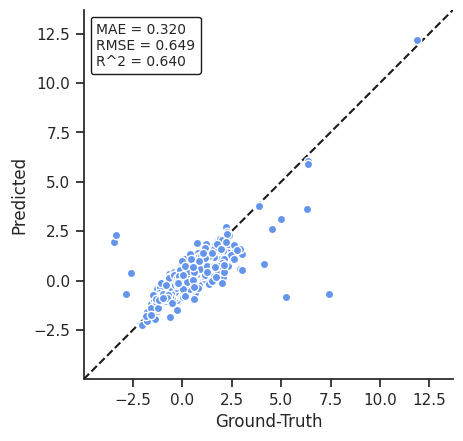

In [134]:
def plot_parity(y_true, y_pred, name, dpi_num, y_pred_unc=None):
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    sns.set(style='ticks')
    plt.plot([axmin, axmax], [axmin, axmax], '--k')

    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', c = 'cornflowerblue', alpha=1, elinewidth=1)
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    ax = plt.gca()
    ax.set_aspect('equal')

    at = AnchoredText(
        f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR^2 = {r2:.3f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    plt.xlabel('Ground-Truth')
    plt.ylabel('Predicted')
    sns.despine()
    plt.savefig(f'{name}.png', dpi = dpi_num)

    plt.show()
    return


plot_parity(targets_poly.cpu(), preds_poly.cpu(), name='test', dpi_num=1700, y_pred_unc=None)


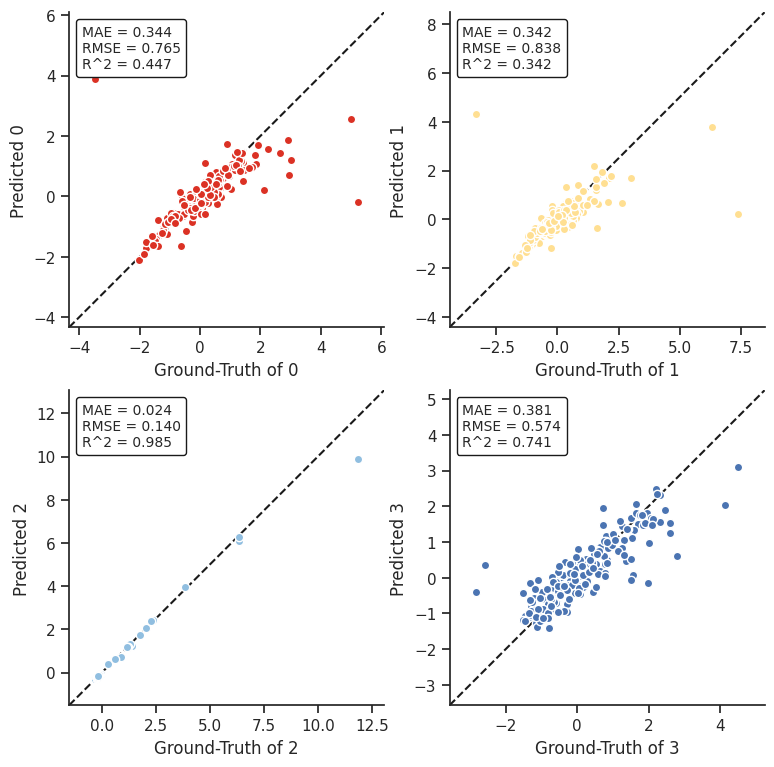

In [9]:
def plot_comp(y_t, y_p, name, dpi_num, num = 4, y_pred_unc=None):
    
    plt.figure(figsize=(9, 9))
    sns.set(style='ticks')
    color = ['#2878b5', '#9ac9db', '#f8ac8c', '#c82423']
    # color = ['#8ECFC9' ,'#FFBE7A', '#FA7F6F', '#82B0D2']
    # color = ['#A1A9D0','#F0988C','#B883D4','#9E9E9E']
    # color = ['#F27970','#BB9727','#54B345' ,'#32B897']
    color = ['#db3124', '#ffdf92', '#90bee0', '#4b74b2']
    for i in range(num):
        plt.subplot(2, 2 ,i+1)
        y_true = y_t[:, i]
        y_pred = y_p[:, i]
        axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
        axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
        mae = mean_absolute_error(y_true, y_pred)
        rmse = mean_squared_error(y_true, y_pred, squared=False)
        r2 = r2_score(y_true, y_pred)
        plt.plot([axmin, axmax], [axmin, axmax], '--k')
        plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', c = color[i], alpha=1, elinewidth=1)
        plt.xlim((axmin, axmax))
        plt.ylim((axmin, axmax))
        ax = plt.gca()
        ax.set_aspect('equal')
        at = AnchoredText(
        f"MAE = {mae:.3f}\nRMSE = {rmse:.3f}\nR^2 = {r2:.3f}", prop=dict(size=10), frameon=True, loc='upper left')
        at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax.add_artist(at)
        plt.xlabel(f'Ground-Truth of {i}')
        plt.ylabel(f'Predicted {i}')
        sns.despine()

    plt.savefig(f'{name}.png', dpi = dpi_num)
    plt.show()
    
    
plot_comp(targets_poly.cpu().reshape(-1, 4), preds_poly.cpu().reshape(-1, 4), name='test-tmp', dpi_num=500, num = 4, y_pred_unc=None)